## Detecting building defects using VGG16

In [1]:
import tensorflow as tf
tf.__version__

'2.9.1'

### Importing and Understanding the dataset

In [2]:
# walk through the folder to know the content

import pathlib
import os

for dirpath, dirname, filenames in os.walk("..\data"):
    print(f"There are {len(dirname)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in ..\data
There are 3 directories and 0 images in ..\data\test_set
There are 0 directories and 32 images in ..\data\test_set\crack
There are 0 directories and 51 images in ..\data\test_set\flakes
There are 0 directories and 37 images in ..\data\test_set\roof
There are 3 directories and 0 images in ..\data\train_set
There are 0 directories and 86 images in ..\data\train_set\crack
There are 0 directories and 176 images in ..\data\train_set\flakes
There are 0 directories and 54 images in ..\data\train_set\roof


In [4]:
# get the names of the classes
import numpy as np

data_dir = pathlib.Path("../data/test_set")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['crack' 'flakes' 'roof']


In [5]:
# visualize the data

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Create a function to show random images from dataset
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    print(target_folder)

    random_image = random.sample(os.listdir(target_folder), 1)

    # plot image using matplotlib
    img = mpimg.imread(target_folder+ "/" + random_image[0])
    plt.imshow(img)
    plt.axis(False)
    plt.title(target_class)
    print(f"Image shape : {img.shape}")

../data/train_set/roof
Image shape : (312, 612, 3)


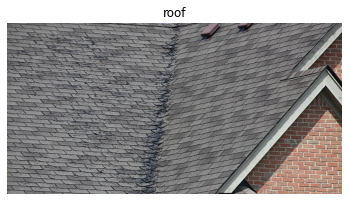

In [6]:
# view random image from training set
view_random_image("../data/train_set/", "roof")

#### Image preprocessing 

In [7]:
# importing ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# get the directory path
train_dir = "../data/train_set"
test_dir = "../data/test_set"

# Create instances for training and test data
train_datagen = ImageDataGenerator(rescale= 1./255,
                                    shear_range= 0.2,
                                    zoom_range= 0.2,
                                    horizontal_flip= True)

test_datagen = ImageDataGenerator(rescale= 1./255)

# Create the test and train data
train_data = train_datagen.flow_from_directory(directory= train_dir,
                                                target_size= (224,224),
                                                batch_size= 32,
                                                class_mode= 'categorical')
                                                
test_data = test_datagen.flow_from_directory(directory= test_dir,
                                                target_size= (224,224),
                                                batch_size= 32,
                                                class_mode= 'categorical')

Found 316 images belonging to 3 classes.
Found 120 images belonging to 3 classes.


#### Creating the model

In [8]:
# imports 
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model


In [9]:

# vgg16 model (Feature extractor) 
INPUT_SHAPE =   (224,224,3)
vgg16_model = VGG16(include_top= False, weights= 'imagenet')
vgg16_model.trainable = False # Freeze the base model

# Create the model using the keras functional API
inputs = layers.Input(shape = INPUT_SHAPE, name = "input_layer")
x = vgg16_model(inputs, training = False)
x = layers.Flatten(name = "flatten_layer")(x)
x = layers.Dense(64, activation= 'relu')(x)
outputs = layers.Dense(len(class_names), activation= "softmax", name = "output_layer")(x)

model_1 = Model(inputs = inputs, outputs = outputs)

# Compile the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics= ['accuracy'])

In [10]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_layer (Flatten)     (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 64)                1605696   
                                                                 
 output_layer (Dense)        (None, 3)                 195       
                                                                 
Total params: 16,320,579
Trainable params: 1,605,891
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# Train the model
history_1 = model_1.fit(
    train_data,
    validation_data = test_data,
    epochs = 10,
    steps_per_epoch = len(train_data),
    validation_steps = len(test_data)
)

Epoch 1/10
 3/10 [========>.....................] - ETA: 1:18 - loss: 3.0630 - accuracy: 0.4565

#### Evaluating the model

In [ ]:
# plotting the learning curves
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.figure(figsize= (10,7))
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure(figsize= (10,7))
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [ ]:
plot_loss_curves(history_1)

In [ ]:
# saving the model
from tensorflow.keras.models import save_model

model_1.save('model_building_defects_vgg16.h5')

In [ ]:
# Testing the model named - model_building_defects_vgg16_custom.h5

model_1.evaluate(test_data)

In [ ]:
# Loading the model - model_building_defects_vgg16.h5
from tensorflow.keras.models import load_model

loaded_model = load_model("model_building_defects_vgg16.h5")

In [ ]:
loaded_model.evaluate(test_data)

#### Making predictions using the model

In [ ]:
# using an image to make predictions
def pred_and_plot(model_name, filename, img_shape = 224):
  random_image = random.sample(os.listdir(filename), 1)
  img = tf.io.read_file(filename + "/" + random_image[0])
  img = tf.image.decode_image(img, channels = 3)
  img = tf.image.resize(img, size = [img_shape, img_shape])
  show_img = img/255.

  # make prediction
  pred = model_name.predict(tf.expand_dims(img, axis =0))
  
  # get the pred class
  pred_class = class_names[tf.argmax(pred[0])]

  # plot the image with prediction
  plt.imshow(show_img)
  plt.title(f"Predicted defect : {pred_class}")
  plt.axis(False)

In [ ]:
pred_and_plot(loaded_model, "../data/test_set/roof")